In [1]:

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1


In [2]:
import pandas as pd
idx = pd.IndexSlice

import datetime as dt
from datetime import date
from datetime import timedelta
import dateutil.parser as dup

%aimport trans.data
%aimport trans.gtrans
%aimport trans.reg
%aimport trans.regpipe
%aimport trans.qfactors

from trans.data import GetData
gd = GetData()
from trans.gtrans import *
from trans.reg import Reg, RegAttr
from trans.regpipe import RegPipe

import trans.qfactors as qf
from trans.date_manip import Date_Manipulator

In [3]:
start = dup.parse("01/01/2015")
#end =   dup.parse("03/15/2018")

today = dt.datetime.combine( date.today(), dt.time.min)
# today = dup.parse( dt.datetime.today().strftime("%m/%d/%Y"))
end = today
start, end

refreshData = False

(datetime.datetime(2015, 1, 1, 0, 0), datetime.datetime(2018, 4, 3, 0, 0))

In [4]:
existing_tickers = gd.existing()
len(existing_tickers)

1118

In [5]:
existing_tickers.sort()
changed_tickers = []
if refreshData:
    changed_tickers = gd.get_data( existing_tickers, start, end)
    cleaned = gd.clean_data(existing_tickers)

Extend A from 03/28/2018 beginning on 03/29/2018 to 04/03/2018.
get_one: Yahoo exception for A: <class 'pandas_datareader._utils.RemoteDataError'> - Unable to read URL: https://query1.finance.yahoo.com/v7/finance/download/A?period1=1522296000&period2=1522814399&interval=1d&events=history&crumb=zUitaUQR%5Cu002FJL
get_one: Yahoo error for A, re-try 1.
Extend AA from 03/28/2018 beginning on 03/29/2018 to 04/03/2018.
Extend AAL from 03/28/2018 beginning on 03/29/2018 to 04/03/2018.
Extend AAN from 03/28/2018 beginning on 03/29/2018 to 04/03/2018.
get_one: Yahoo exception for AAN: <class 'pandas_datareader._utils.RemoteDataError'> - Unable to read URL: https://query1.finance.yahoo.com/v7/finance/download/AAN?period1=1522296000&period2=1522814399&interval=1d&events=history&crumb=UVFPA.A%5Cu002Fhxq
get_one: Yahoo error for AAN, re-try 1.
get_one: Yahoo exception for AAN: <class 'pandas_datareader._utils.RemoteDataError'> - Unable to read URL: https://query1.finance.yahoo.com/v7/finance/downlo

In [6]:
universe = gd.get_r1000_tickers()
len(universe)

missing_universe = list(set(universe) - set(existing_tickers))
missing_universe.sort()
print("No data for following R1000 names: {}".format(", ".join(missing_universe)))

universe = list(set(universe) - set(missing_universe))
universe.sort()
print("Available universe has {} tickers".format(len(universe)))

mom = qf.MomentumPipe(universe)
price_df = mom.load_prices( start, end)

987

No data for following R1000 names: ALR, AMSG, AWH, BCR, BEAV, BF.A, BF.B, BHI, BKFS, BRCD, CAA, CAB, CCP, COH, CPGX, CSAL, CSC, CST, DD, DOW, EMC, ENH, EQY, FEIC, FNFG, GAS, HAR, HOT, IHS, IM, IMS, ITC, JW.A, KATE, LGF, LLTC, LNKD, LVLT, LXK, MDVN, MFS, MJN, MRD, N, NRF, NSAM, PNRA, PNY, PPS, Q, RAI, RAX, RICE, SCTY, SPLS, SSS, STJ, STR, TCB, TE, TSO, TYC, UA.C, VAL, VNTV, VWR, WFM, WOOF, WWAV, YHOO
Available universe has 917 tickers


In [7]:
price_df.shape

(818, 5508)

In [8]:
dm = Date_Manipulator( mom.price_df.index )
eom_in_idx = dm.periodic_in_idx_end_of_month(end)
mom.set_endDates( eom_in_idx )

End 2018-04-03 00:00:00, last 2018-04-30 00:00:00


In [9]:
price_attr = "Adj Close"
ret_attr = "Ret"
daily_ret_df = mom.create_dailyReturns(price_attr, ret_attr )

## 12m1m: 11 month return beginning 12m ago and ending 1m ago
- so 11 month return, shift forward 1 mo

In [10]:
period_ret_attr = ret_attr + " yearly"
yearly_ret_df = mom.create_periodReturns(price_attr, period_ret_attr, periods=11)

yearly_ret_df = mom.period_ret_df
shifted_yearly_ret_df = ShiftTransformer(1).fit_transform(yearly_ret_df)
mom.period_ret_df = shifted_yearly_ret_df

In [11]:

yearly_ret_df.loc["2017-12-01":"2018-03-20", idx[ period_ret_attr, "NFLX"]]
shifted_yearly_ret_df.loc["2017-12-01":"2018-03-20", idx[ period_ret_attr, "NFLX"]]

Dt
2017-12-29    0.364224
2018-01-31    0.901780
2018-02-28    0.971315
Freq: BM, Name: (Ret yearly, NFLX), dtype: float64

Dt
2017-12-29    0.515186
2018-01-31    0.364224
2018-02-28    0.901780
Freq: BM, Name: (Ret yearly, NFLX), dtype: float64

In [12]:
daily_rank_df = mom.create_ranks()

In [37]:
s = daily_rank_df.loc["2018-03-01", idx["Rank",:]]
s_defined = s[ s.isnull() == False ]
size = s_defined.size
size

908

In [25]:
factor_ret_attr = ret_attr + " Factor"
factor_df = mom.create_factor()

In [26]:
f_ret = factor_df.loc[:, idx["Ret", "Port net"]]
f_ret.loc["2018-01-01":]

Dt
2018-01-02   -0.008503
2018-01-03    0.005772
2018-01-04    0.000411
2018-01-05    0.008272
2018-01-08    0.004627
2018-01-09    0.007405
2018-01-10   -0.005871
2018-01-11   -0.007414
2018-01-12   -0.001534
2018-01-16    0.005842
2018-01-17    0.013100
2018-01-18    0.007069
2018-01-19    0.002187
2018-01-22   -0.008927
2018-01-23    0.000254
2018-01-24    0.000386
2018-01-25    0.008171
2018-01-26    0.008840
2018-01-29   -0.001150
2018-01-30    0.009397
2018-01-31    0.002692
2018-02-01   -0.000288
2018-02-02    0.004016
2018-02-05   -0.001322
2018-02-06    0.000148
2018-02-07    0.004988
2018-02-08   -0.008284
2018-02-09    0.010139
2018-02-12    0.003409
2018-02-13    0.009724
                ...   
2018-02-20    0.004827
2018-02-21    0.008576
2018-02-22   -0.002399
2018-02-23   -0.003249
2018-02-26    0.000994
2018-02-27    0.002044
2018-02-28    0.008438
2018-03-01   -0.006452
2018-03-02   -0.004463
2018-03-05   -0.008046
2018-03-06    0.004734
2018-03-07    0.007693
2018-03-

## Standard deviation computed over last year

In [27]:
std_dev = f_ret.loc[end - dt.timedelta(days=365) :].std()

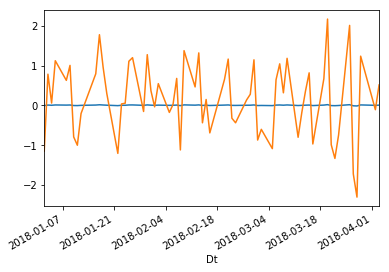

In [28]:
%matplotlib inline
f_ret_recent = f_ret.loc["2018-01-01":]
f_ret_recent.plot()
f_ret_recent_z = f_ret_recent/std_dev

f_ret_recent_z.plot()

In [29]:
gd.save_data(factor_df, "mom_r1000_12m1m.pkl")

In [30]:
factor_df.to_csv("mom_r1000_12m1m.csv")

In [31]:
f_ret_recent_z.tail()

Dt
2018-03-27   -1.727765
2018-03-28   -2.311214
2018-03-29    1.236292
2018-04-02   -0.110941
2018-04-03    0.512004
Name: (Ret, Port net), dtype: float64

In [39]:
s = daily_rank_df.loc["2018-03-01", idx["Rank",:]]
s_defined = s[ s.isnull() == False ]
size = s_defined.size
size

row = factor_df.loc["2018-03-01", idx[ "weight",:]]

size
size * 0.20
row[ row < 0].sum()
row[ row > 0].sum()

908

908

181.60000000000002

-181.0

181.0